In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import os
import math

In [2]:
train_messy = "alien"
train_clean= "predator"
image_size=128

In [3]:
def train_data():
    train_data_messy = [] 
    train_data_clean=[]
    for image1 in tqdm(os.listdir(train_messy)): 
        path = os.path.join(train_messy, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_messy.append(img1) 
        
    for image2 in tqdm(os.listdir(train_clean)): 
        path = os.path.join(train_clean, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_clean.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_messy),np.asarray(train_data_clean)),axis=0)
    return train_data 

In [4]:
train_data = train_data() 
x_data=train_data
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))
z1 = np.zeros(347)
o1 = np.ones(347)
Y_train = np.concatenate((o1, z1), axis=0)
y_data=Y_train.reshape(x_data.shape[0],1)
x_data=x_data.reshape(x_data.shape[0],-1).T
print(x_data.shape)
print(y_data.shape)
# x_data = list(np.random.permutation(x_data[1]))
a=int(694*0.8)
print(a)
x_train=x_data[:,0:a]
y_train=y_data.T[:,0:a]
x_test=x_data[:,a:694]
y_test=y_data.T[:,a:694]

100%|███████████████████████████████████████████████████████████████████████████████| 347/347 [00:00<00:00, 784.50it/s]


(16384, 694)
(694, 1)
555


In [5]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ



def initialize_parameters_deep(layer_dims):
    
    parameters = {}
    v = {}
    s = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*(2/ np.sqrt(layer_dims[l-1])) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
        s["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        s["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
       
    return parameters,v,s

def linear_forward(A, W, b):
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1])) 
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)   
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache) 
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

def update_parameters_with_adam(parameters, grads, v, s,t,learning_rate = 0.01,beta1 = 0.9, beta2 = 0.999,epsilon = 1e-8):
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    for l in range(L):
        v["dW" + str(l+1)] = beta1*(v["dW" + str(l+1)]) + (1 - beta1)*(grads['dW' + str(l+1)])
        v["db" + str(l+1)] = beta1*(v["db" + str(l+1)]) + (1 - beta1)*(grads['db' + str(l+1)])
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] /(1 - np.power(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] /(1 - np.power(beta1,t))
        s["dW" + str(l+1)] = beta2*(s["dW" + str(l+1)]) + (1 - beta2)*(np.power(grads['dW' + str(l+1)],2))
        s["db" + str(l+1)] = beta2*(s["db" + str(l+1)]) + (1 - beta2)*(np.power(grads['db' + str(l+1)],2))
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] /(1 - np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] /(1 - np.power(beta2,t))
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(v_corrected["dW" + str(l+1)])/(np.sqrt(s_corrected["dW" + str(l+1)] )+ epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(v_corrected["db" + str(l+1)])/(np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
    return parameters

def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p))/m))   
    return p


In [6]:
# parameters = initialize_parameters_deep([16384,5,1])
# AL,cache = L_model_forward(x_train, parameters)
# grads = L_model_backward(AL,y_train, cache)
# parameters1 = update_parameters(parameters, grads, 0.1)
# p = predict(x_train,y_train,parameters1)
# p1 = predict(x_test,y_test,parameters1)
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    t = 0
    costs = []  
    parameters,v,s = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        t=t+1
        parameters = update_parameters(parameters,grads,learning_rate)
#         parameters = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
#plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.671777
Cost after iteration 100: 0.579785
Cost after iteration 200: 0.527169
Cost after iteration 300: 0.499088
Cost after iteration 400: 0.424695


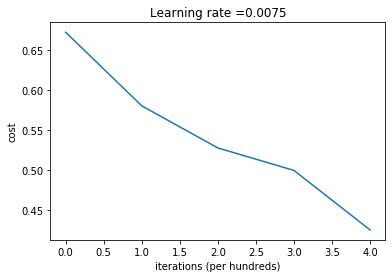

In [19]:
parameters = L_layer_model(x_train, y_train,[16384,20,7,1], learning_rate = 0.0075, num_iterations = 500, print_cost=True)

In [20]:
p = predict(x_train,y_train,parameters)
p1 = predict(x_test,y_test,parameters)

Accuracy: 0.863063063063063
Accuracy: 0.8705035971223022
